In [36]:
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 600

In [37]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

In [38]:

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

shape of all data:  (194, 360000)


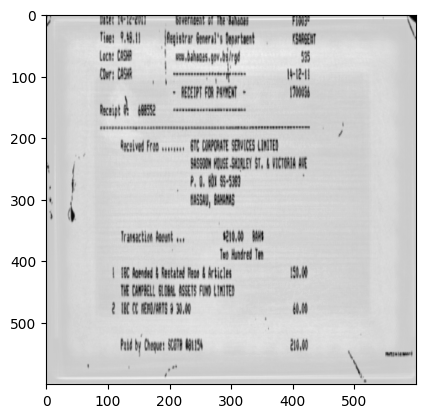

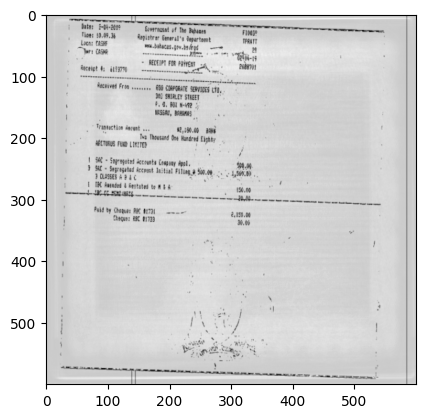

In [39]:

print('shape of all data: ', preprocessed_images_centered.shape)    # (n_samples, n_features)
for img in preprocessed_images_centered[:2]:
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.show()

In [40]:
# PCA needs more samples than features, cf. https://stackoverflow.com/questions/51040075/why-sklearn-pca-needs-more-samples-than-new-featuresn-components
# otherwise the number of new faetures will be way smaller than the original number of features
# number of components to keep: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = decomposition.PCA(n_components=0.95, whiten=True)
#print(preprocessed_images[0].shape)
pca_img = pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', pca.components_.shape)    # (n_new_features/ n_components, n_features)
print('PCA return shape: ', pca_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_img)

PCA components:  (159, 360000)
PCA return shape:  (194, 159)
PCA image:  [[-0.34634772 -0.32713503  0.23491706 ... -0.4032526   0.50540966
  -0.08883873]
 [-0.36620033  0.29783598  0.52958775 ... -0.07529329  3.1464632
   2.1019042 ]
 [ 0.5668558   0.20772775  9.160192   ... -0.07665431  0.09061153
  -0.11085415]
 ...
 [-0.20437457 -0.48260477 -0.04621928 ... -0.06149068  0.4347566
  -0.39918292]
 [ 3.3648775   1.4137287  -0.38372564 ... -0.18276103  0.05855999
   0.16887212]
 [-0.38861105 -0.08941118 -0.43958828 ... -0.84193754 -0.51569545
   0.5237475 ]]


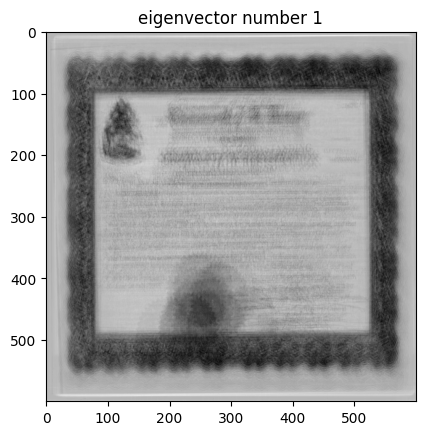

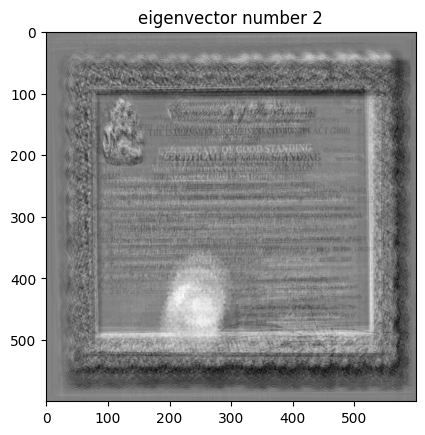

In [41]:
# plot eigenvectors as images
i = 1
for img in pca.components_[:2]: # component is (parallel to) eigenvector, cf. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    plt.imshow(img.reshape(IMG_SIZE,IMG_SIZE), cmap='gray')
    plt.title('eigenvector number ' + str(i))
    i += 1
    plt.show()

    # compare eigenvectors to get 'what they show (eg. Belichtung, Kontrast, etc.)'
    # TODO: residuals/ rescosntruction error, to see how much information is lost, if representative

In [42]:
# save representation of images in lower dimension (linear combination of eigenvectors) in dataframe
pca_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_img[i]], index=pca_df.index[[i]])

pca_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34634772, -0.32713503, 0.23491706, 0.83851..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36620033, 0.29783598, 0.52958775, -0.02569..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5668558, 0.20772775, 9.160192, 1.9091265, 5..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884235, 0.30937096, 0.76894003, 0.3910606..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43358627, -0.42436287, -0.54459655, -0.178..."
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31547618, -0.070501745, -0.6787747, -0.002..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30039185, 0.05342531, 0.1682269, 0.2596383..."
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20437457, -0.48260477, -0.04621928, 0.0868..."


In [43]:
# identify clusters by similar weights (linear combination) of eigenvectors
NUM_CLASSES = 4
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_df['pca_weights'].to_list())
pca_df['cluster'] = kmeans.labels_
display(pca_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34634772, -0.32713503, 0.23491706, 0.83851...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36620033, 0.29783598, 0.52958775, -0.02569...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5668558, 0.20772775, 9.160192, 1.9091265, 5...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.2884235, 0.30937096, 0.76894003, 0.3910606...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.43358627, -0.42436287, -0.54459655, -0.178...",3
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31547618, -0.070501745, -0.6787747, -0.002...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30039185, 0.05342531, 0.1682269, 0.2596383...",3
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20437457, -0.48260477, -0.04621928, 0.0868...",3


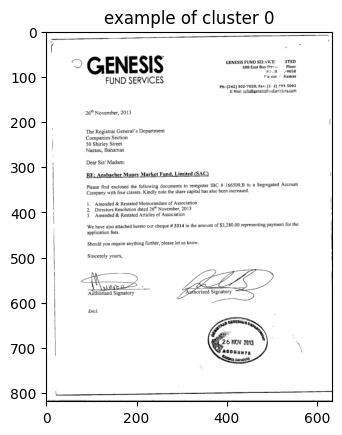

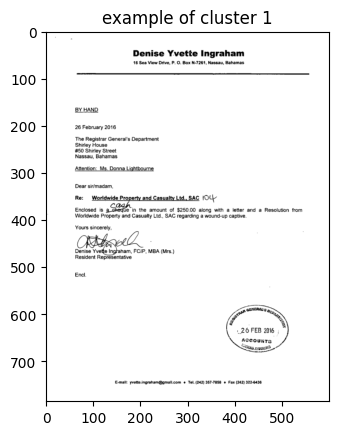

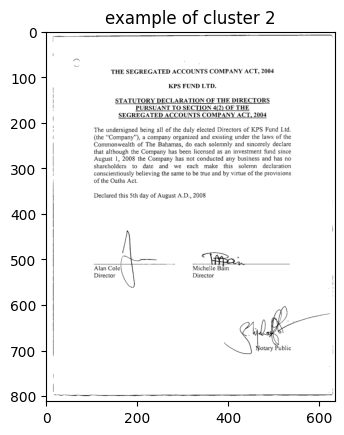

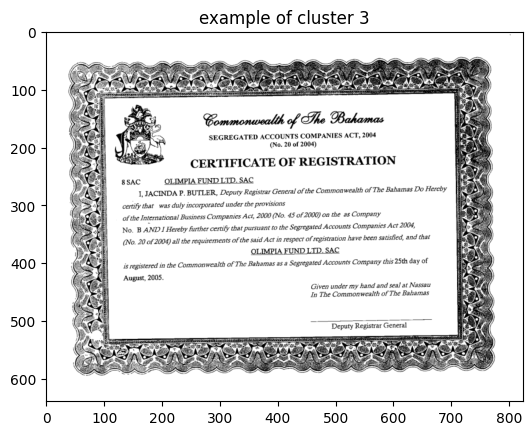

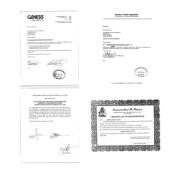

In [44]:
# display sample document per class
example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_df[pca_df['cluster'] == i].sample(1).index.values[0]
    example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of cluster ' + str(i))
    plt.show()

create_image_matrix(example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

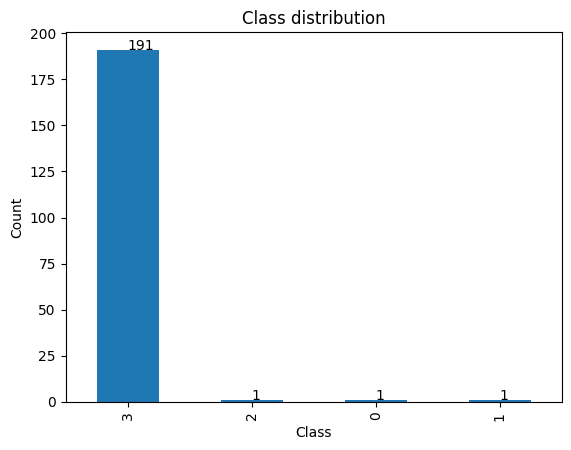

In [45]:
# class/ cluster distribution
pca_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
cluster_counts = pca_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_df['cluster'].value_counts())):
        plt.text(i, cluster_counts[i], cluster_counts[i])

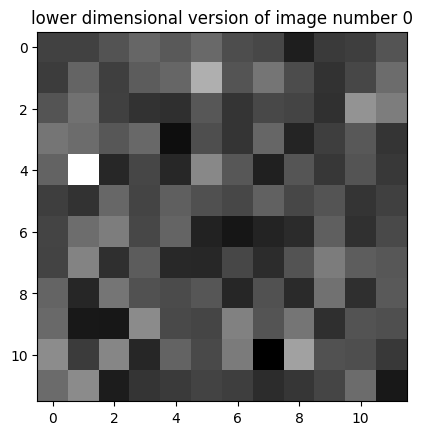

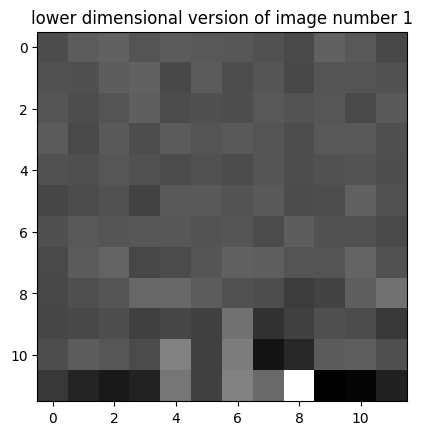

In [46]:
# visualize the compressed data, i.e. the weights/ factors of PCA components, as an image
# transformed pictures in lower dimensional subspace (weights of PCA components)
for i in range(len(pca_img[:2])):
    img = pca_img[i]
    dim = int(sqrt(len(img)))
    # automatically transform image using -1, cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
    quadratic_img = img[:dim**2].reshape(-1, dim)#img[:dim**2].reshape(dim, dim)
    plt.imshow(quadratic_img, cmap='gray')
    plt.title('lower dimensional version of image number ' + str(i))
    plt.show()

In [47]:
# use PCA to reduce dimensionality (image -> point in 2 dimensional space)
# cf. https://www.datacamp.com/tutorial/principal-component-analysis-in-python
d2_pca = decomposition.PCA(n_components=2, whiten=True)
#print(preprocessed_images[0].shape)
pca_2d_img = d2_pca.fit_transform(preprocessed_images_centered)
print('PCA components: ', d2_pca.components_.shape, 'Principal axes in feature space = directions of maximum variance')    # (n_new_features/ n_components, n_features)
print('PCA return/ image shape: ', pca_2d_img.shape)  # (n_samples, n_new_features/ n_components)
print('PCA image: ', pca_2d_img)

PCA components:  (2, 360000) Principal axes in feature space = directions of maximum variance
PCA return/ image shape:  (194, 2)
PCA image:  [[-3.46404880e-01 -3.26927036e-01]
 [-3.66250008e-01  2.97931373e-01]
 [ 5.66970110e-01  2.06824452e-01]
 [-2.88445771e-01  3.09618443e-01]
 [-4.33654696e-01 -4.24483925e-01]
 [-3.60889167e-01  3.51281673e-01]
 [-4.89749998e-01 -3.34215492e-01]
 [-4.69095260e-01 -2.17441663e-01]
 [-2.59473681e-01 -1.35068536e-01]
 [ 2.68319082e+00  1.91569901e+00]
 [-4.73633528e-01 -4.85563099e-01]
 [-5.46603560e-01  1.04370363e-01]
 [ 3.07976770e+00  2.35982791e-01]
 [-4.15833056e-01 -8.61615688e-02]
 [-1.90707400e-01  2.15965196e-01]
 [-4.07719612e-01  1.74018502e-01]
 [-2.66363353e-01  5.74656725e-01]
 [-3.82630825e-01  4.15658727e-02]
 [-1.74659789e-01  2.53104270e-01]
 [-3.16851467e-01  2.35202625e-01]
 [-2.79990643e-01 -2.79406816e-01]
 [-2.27828339e-01 -1.70017526e-01]
 [-3.84884268e-01 -5.08626282e-01]
 [-5.38831770e-01 -6.43724799e-01]
 [-5.22882462e-01 -

In [48]:
# save representation of images by linear combination of eigenvectors in dataframe
pca_2d_df = pd.DataFrame({'path': image_paths, 'pca_weights': 0})
pca_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    pca_2d_df.loc[[image_paths[i]], 'pca_weights'] = pd.Series([pca_2d_img[i]], index=pca_2d_df.index[[i]])

pca_2d_df.to_json('pca_2d_df.json', index=True)
pca_2d_df

,pca_weights
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640488, -0.32692704]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625, 0.29793137]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669701, 0.20682445]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844577, 0.30961844]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.4336547, -0.42448393]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549248, -0.07063169]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040613, 0.053496037]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440562, -0.4827074]"


In [49]:
# identify clusters by similar weights (linear combination) of eigenvectors
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(pca_2d_df['pca_weights'].to_list())
pca_2d_df['cluster'] = d2_kmeans.labels_
display(pca_2d_df)

,pca_weights,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-0.34640488, -0.32692704]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-0.36625, 0.29793137]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[0.5669701, 0.20682445]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-0.28844577, 0.30961844]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-0.4336547, -0.42448393]",0
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-0.31549248, -0.07063169]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-0.30040613, 0.053496037]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-0.20440562, -0.4827074]",0


Text(0.5, 1.0, '2D representation of images clustered by KMeans')

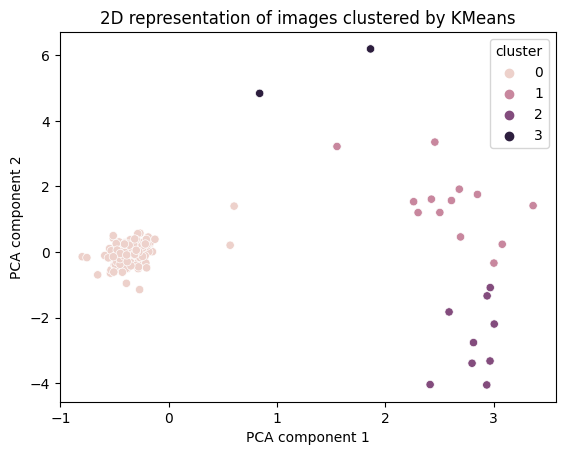

In [50]:
sns.scatterplot(x=pca_2d_df['pca_weights'].apply(lambda x: x[0]), y=pca_2d_df['pca_weights'].apply(lambda x: x[1]), hue=pca_2d_df['cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

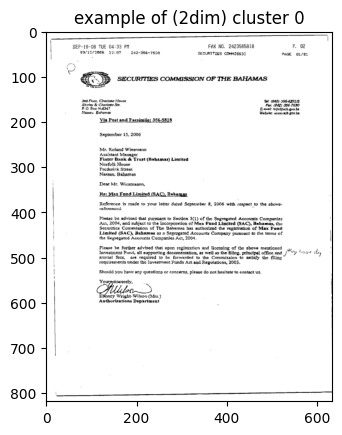

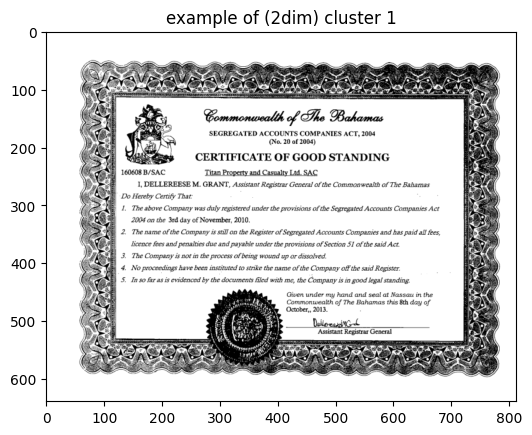

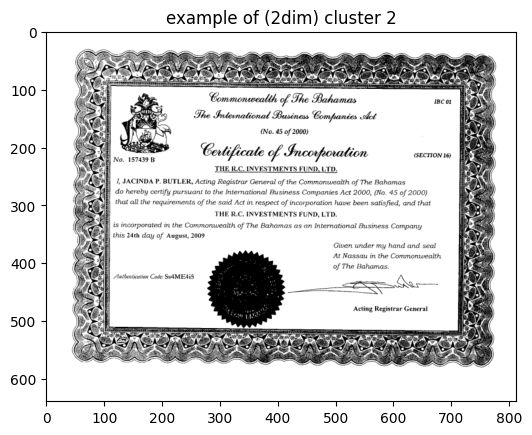

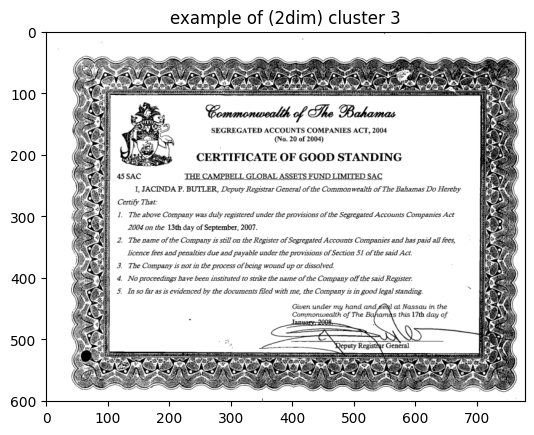

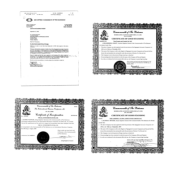

In [51]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = pca_2d_df[pca_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

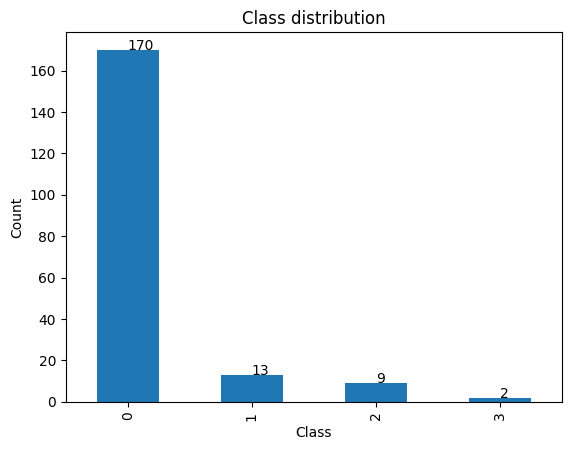

In [52]:
# class/ cluster distribution
pca_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = pca_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(pca_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])

# PCA

### PCA components: 
- Principal axes in feature space = directions of maximum variance
- Parallel to eigenvectors

### PCA explained variance:
- Amount of variance explained by each of the selected components
- Ratio: same, but percentage

### PCA n_components:
- Number of components to keep

### PCA return values:
- samples in new (lower dimensional) feature space
